Keras is a high-level library designed to work on top of Theano or Tensorflow. The main idea of Keras is to be an easy to use, minimalistic API which can be used to build and deploy deep learning models quickly. Due to its simplicity, Keras' syntax and model building pipeline is  easy to learn for beginners (though it does not compromise on flexibility - you can do almost everything with Keras which you can do with pure Tensorflow or Theano).

Keras by default uses TensorFlow as the backend. If you wish to use it with Theano backend, you need to find the 'keras.json' file and change the "backend":"tensorflow" to "backend":"theano" in the .json file.

In this notebook, we'll implement a L-layer deep model on MNIST dataset using Keras. The MNIST dataset contains tens of thousands of scanned images of handwritten digits, together with their correct classifications. MNIST's name comes from the fact that it is a modified subset of two data sets collected by NIST, the United States' National Institute of Standards and Technolog

To use Keras, we'll need to install Keras and Tensorflow.
<br>
Run the following commands if we don't have Keras and TensorFlow already installed.
<br>
1. ! pip install TensorFlow
<br>
2. ! pip install keras
<br>
3. ! pip install msgpack


There are six main steps in building a model using Keras:

1.Load the data

2.Define the model

3.Compile the model

4.Fit the model

4.Evaluate the model

5.Make predictions


In [6]:
import numpy as np
import pandas as pd
import pickle
import gzip
import matplotlib.pyplot as plt
import h5py

from PIL import Image
from scipy import ndimage

from keras.models import Sequential
from keras.layers import Dropout ,Dense , BatchNormalization, Activation
from keras import regularizers

np.random.seed(7)

%matplotlib inline

The MNIST dataset we use here is 'mnist.pkl.gz' which is divided into training, validation and test data. The following function <i> load_data() </i> unpacks the file and extracts the training, validation and test data.

In [9]:
def load_data():
  f=gzip.open('/content/drive/MyDrive/DataSetCNN/mnist.pkl.gz','rb')
  f.seek(0)
  training_data, validation_data, test_data = pickle.load(f , encoding='latin1')
  f.close()
  return (training_data, validation_data, test_data)

In [10]:
training_data, validation_data, test_data = load_data()

In [13]:
training_data

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32),
 array([5, 0, 4, ..., 8, 4, 8]))

In [15]:
print("The feature dataset is:"+str(training_data[0]))
print("The target dataset is:"+str(training_data[1]))
print("The number of examples in the training dataset is:" + str(len(training_data[0])))
print("The number of points in a single input is:" + str(len(training_data[0][1])))

The feature dataset is:[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
The target dataset is:[5 0 4 ... 8 4 8]
The number of examples in the training dataset is:50000
The number of points in a single input is:784


The target variable is converted to a one hot matrix. We use the function <i> one_hot </i> to convert the target dataset to one hot encoding.

In [18]:
def one_hot(j):
  n=j.shape[0]
  new_array=np.zeros((10,n))
  index=0
  for res in j:
    new_array[res][index]=1.0
    index=index+1
  return new_array

Check for <i>one_hot()</i> function created

In [21]:
data = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
one_hot(data)

array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])

In [26]:
def data_wrapper():
  tr_d, va_d, te_d = load_data()

  training_inputs = np.array(tr_d[0][:]).T
  training_results = np.array(tr_d[1][:])
  train_set_y = one_hot(training_results)

  validation_inputs = np.array(va_d[0][:]).T
  validation_results = np.array(va_d[1][:])
  validation_set_y = one_hot(validation_results)
  
  test_inputs = np.array(te_d[0][:]).T
  test_results = np.array(te_d[1][:])
  test_set_y = one_hot(test_results)

  return (training_inputs, train_set_y, validation_inputs, validation_set_y)

In [27]:
train_set_x, train_set_y, test_set_x, test_set_y = data_wrapper()

For implementing in Keras, the input training and input target dataset are supposed to have shape (m, n) where m is the number of training samples and n is the number of parts in a single input.
<br> Hence, let create the desired dataset shapes by taking transpose.

In [28]:
train_set_x = train_set_x.T
train_set_y = train_set_y.T
test_set_x = test_set_x.T
test_set_y = test_set_y.T

Now, let's see if the datasets are in the desired shape:

In [29]:
print ("train_set_x shape: " + str(train_set_x.shape))
print ("train_set_y shape: " + str(train_set_y.shape))
print ("test_set_x shape: " + str(test_set_x.shape))
print ("test_set_y shape: " + str(test_set_y.shape))

train_set_x shape: (50000, 784)
train_set_y shape: (50000, 10)
test_set_x shape: (10000, 784)
test_set_y shape: (10000, 10)


Now let us visualise the dataset. we can change the index to see if the training data has been correctly tagged.

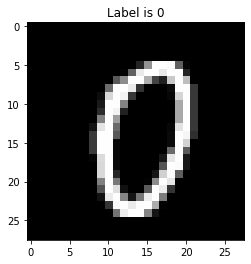

In [31]:
index=1000
k = train_set_x[index,:]
k = k.reshape((28, 28))
plt.title('Label is {label}'.format(label=training_data[1][index]))
plt.imshow(k, cmap='gray')

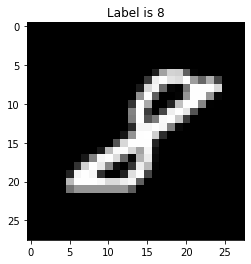

In [32]:
index=1009
k = train_set_x[index,:]
k = k.reshape((28, 28))
plt.title('Label is {label}'.format(label=training_data[1][index]))
plt.imshow(k, cmap='gray')

Keras is a framework. So, to implement a neural network model in Keras, we first create an instance of Sequential(). <br>
The Sequential model is a linear stack of layers. We then keep adding Dense layers that are fully connected layers as we desire.

We will add Dropouts and regularizers to improve model performance.

Create Model

In [33]:
nn_model = Sequential()
nn_model.add(Dense(35, input_dim=784, activation='relu'))
nn_model.add(Dropout(0.3))
nn_model.add(Dense(21, activation='relu'))
nn_model.add(Dense(10, activation='softmax'))

Before we run the model on the training datasets, we compile the model in which we define various things like the loss function, the optimizer and the evaluation metric.

In [34]:
nn_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Now, to fit the model on the training input and training target dataset, we run the following command using a minibatch of size 10 and 10 epochs.

In [35]:
nn_model.fit(train_set_x, train_set_y, epochs=10, batch_size=10)

Epoch 1/10
5000/5000 [==============================] - 9s 2ms/step - loss: 0.7409 - accuracy: 0.7654
Epoch 2/10
5000/5000 [==============================] - 9s 2ms/step - loss: 0.3170 - accuracy: 0.9027
Epoch 3/10
5000/5000 [==============================] - 9s 2ms/step - loss: 0.2773 - accuracy: 0.9144
Epoch 4/10
5000/5000 [==============================] - 9s 2ms/step - loss: 0.2525 - accuracy: 0.9218
Epoch 5/10
5000/5000 [==============================] - 9s 2ms/step - loss: 0.2377 - accuracy: 0.9252
Epoch 6/10
5000/5000 [==============================] - 9s 2ms/step - loss: 0.2217 - accuracy: 0.9284
Epoch 7/10
5000/5000 [==============================] - 9s 2ms/step - loss: 0.2187 - accuracy: 0.9303
Epoch 8/10
5000/5000 [==============================] - 8s 2ms/step - loss: 0.2209 - accuracy: 0.9319
Epoch 9/10
5000/5000 [==============================] - 9s 2ms/step - loss: 0.2057 - accuracy: 0.9332
Epoch 10/10
5000/5000 [==============================] - 9s 2ms/step - loss: 0.203

In [36]:
scores_train = nn_model.evaluate(train_set_x, train_set_y)
print("\n%s: %.2f%%" % (nn_model.metrics_names[1], scores_train[1]*100))

1563/1563 [==============================] - 2s 1ms/step - loss: 0.0886 - accuracy: 0.9726

accuracy: 97.26%


We can see that the model has ~ 97% accuracy on the training dataset.
Now, let's make predictions on the test dataset.

In [37]:
predictions=nn_model.predict(test_set_x)
predictions=np.argmax(predictions, axis=1)
predictions

array([3, 8, 6, ..., 5, 6, 8])

In [38]:
score_test = nn_model.evaluate(test_set_x, test_set_y)
print("\n%s: %.2f%%" % (nn_model.metrics_names[1], score_test[1]*100))

313/313 [==============================] - 0s 1ms/step - loss: 0.1214 - accuracy: 0.9659

accuracy: 96.59%


We can see that the model has ~97% accuracy on the training dataset.


Try and look at the different test cases and check which all have gone wrong. Feel free to change the index numbers.

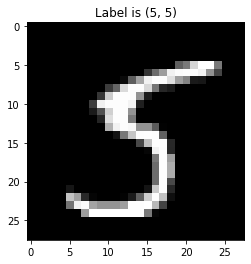

In [40]:
index=9997
k = test_set_x[index,:]
k = k.reshape((28,28))
plt.title('Label is {label}'.format(label=(predictions[index],np.argmax(test_set_y,axis=1)[index])))
plt.imshow(k, cmap='gray')